<a href="https://colab.research.google.com/github/majaIlievska90/Airborne-emssion-demo/blob/main/airborne_emission_methodology_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# Air Quality Data Modelling Demo (Helsinki)
#Air quality measurements which are collected using devices installed on trams from Helsinki.
#Three sensor sets have been moving on the streets of Helsinki.
# Author: Maja Ilievska

#The dataset has been downloaded from Helsinki Region Infoshare service on 09.11.2025
#under the license Creative Commons Attribution 4.0.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

##read the data from 08.2019
file = "sporametri-movingsites-data0219.csv.gz"
file_supersite="/content/sporametri-supersite-data0219.csv.gz"

df_moving = pd.read_csv(file, compression="gzip")
df_supersite = pd.read_csv(file_supersite, compression="gzip")
dataframes = [df_moving, df_supersite]
#print(df_supersite.head())
#print(df_supersite['spora-id'].describe())

#inspect the dataset
#print(df_moving.shape)
#print(df_moving.columns)
#print(df_moving.head())

#convert to pandas datetime format
for df in dataframes:
  df['time'] = pd.to_datetime(df['timestamp'], unit='s')  # 'unit=s' for seconds since epoch
#df_moving = df_moving.set_index('time')
#df_supersite = df_supersite.set_index('time')
print(df_moving.head())
print(df_supersite.head())

##handle the negative values
pollutants = ['NO', 'NO2', 'O3', 'CO']  # adjust to your column names
for df in dataframes:
  for p in pollutants:
    if p in df.columns:
        df[p] = df[p].clip(lower=0)

##since the data is spanning 25 hours only, I will resample for 5min average.
##I will select temperture and humidty to use them as predictors for regression model.
combined = pd.concat([df_supersite, df_moving])
combined = combined.set_index('time')
print(combined.head())
df_resampled = combined[pollutants + ['spora-id','BME680_temperature', 'BME680_humidity']].resample('5min').mean().interpolate()

df_resampled['hour'] = df_resampled.index.hour
#print(df_resampled.head())
print(df_resampled['spora-id'].describe())





    timestamp  spora-id   latitude  longitude     NO    NO2      O3     CO  \
0  1550636934         2  60.162872  24.923164  0.009  0.009  0.0002  0.061   
1  1550636935         2  60.162838  24.923223  0.011  0.011  0.0001  0.055   
2  1550636936         2  60.162811  24.923281  0.011  0.011  0.0001  0.054   
3  1550636937         2  60.162781  24.923323  0.011  0.011  0.0000  0.053   
4  1550636938         2  60.162750  24.923347  0.011  0.011  0.0000  0.034   

   BME680_pressure  BME680_humidity  BME680_temperature  comment  \
0          99055.0            23.76               29.35      NaN   
1          99050.0            23.76               29.35      NaN   
2          99048.0            23.75               29.35      NaN   
3          99048.0            23.77               29.36      NaN   
4          99058.0            23.75               29.35      NaN   

                 time  
0 2019-02-20 04:28:54  
1 2019-02-20 04:28:55  
2 2019-02-20 04:28:56  
3 2019-02-20 04:28:57  
4 

In [51]:
 #regresion to model the effect of the variables on NO2
X = df_resampled[['spora-id','BME680_temperature', 'BME680_humidity', 'hour', 'O3','CO']]
y = df_resampled['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


intercept: -0.0028142766292977833
slope: [ 2.47595525e-03  1.60911815e-04 -1.72739560e-05 -7.34308790e-06
  2.01258078e+00  5.13902476e-02]
R²: 0.15415387918101242
RMSE: 9.431748552008244e-06


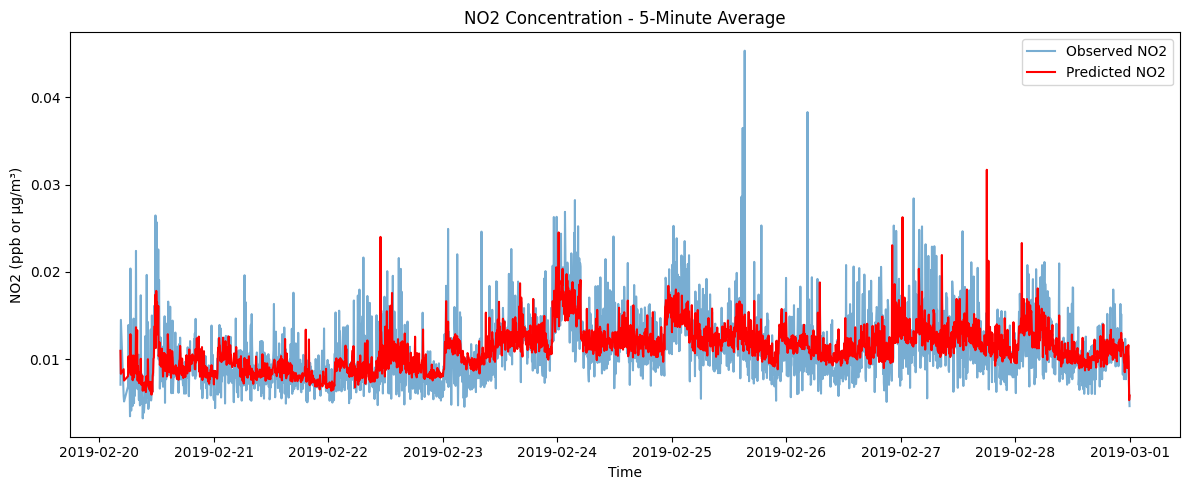

In [52]:
##Visulazation

y_pred_full = model.predict(X)
plt.figure(figsize=(12,5))
plt.plot(df_resampled.index, df_resampled['NO2'], label='Observed NO2', alpha=0.6)
plt.plot(df_resampled.index, y_pred_full, label='Predicted NO2', color='red')
plt.xlabel("Time")
plt.ylabel("NO2 (ppb or µg/m³)")
plt.title("NO2 Concentration - 5-Minute Average")
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
##trying random forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

R²: 0.1420552501065564
RMSE: 9.566656337769322e-06


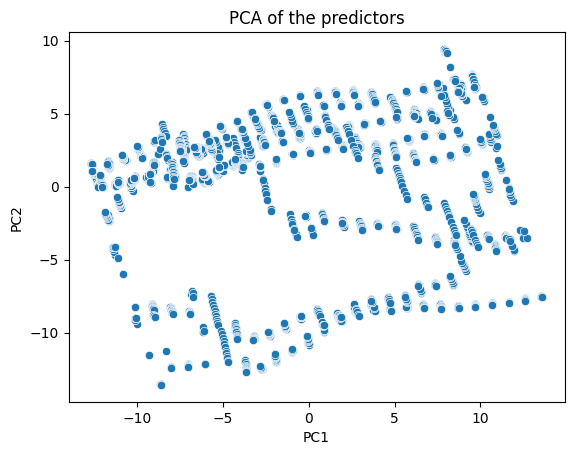

[3 3 3 ... 4 4 4]
Silhouette score: 0.343


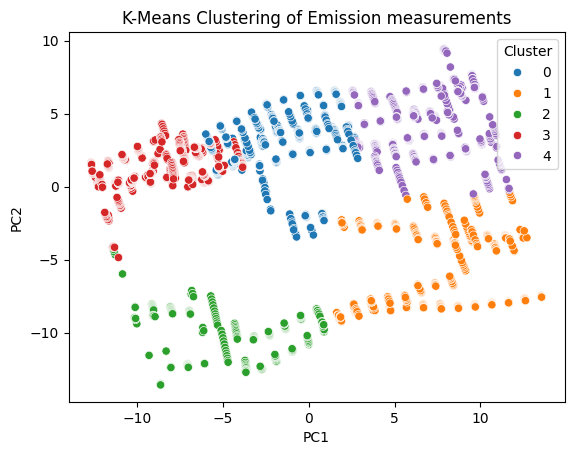

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title("PCA of the predictors")
plt.show()


##trying k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster samples into groups
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)
print(labels)

silhouette = silhouette_score(X, labels)
print(f"Silhouette score: {silhouette:.3f}")

pca_df['Cluster'] = labels
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("K-Means Clustering of Emission measurements")
plt.show()


In [64]:
#explore the clusters
#combined['cluster'] = kmeans.labels_
print(df_resampled.shape)
print(kmeans.labels_.shape)
df_resampled['cluster'] = kmeans.labels_

df_resampled.loc[df_resampled['cluster'] == 3]

(2539, 9)
(2539,)


,NO,NO2,O3,CO,spora-id,BME680_temperature,BME680_humidity,hour,cluster
time,,,,,,,,,
2019-02-20 04:25:00,0.007061,0.007061,0.000389,0.072621,2.0,29.397576,23.672727,4,3
2019-02-20 04:30:00,0.014490,0.014490,0.000442,0.018755,2.0,29.515430,23.418212,4,3
2019-02-20 04:35:00,0.013242,0.013242,0.000419,0.021531,2.0,29.379840,23.331818,4,3
2019-02-20 04:40:00,0.011994,0.011994,0.000397,0.024306,2.0,29.244249,23.245425,4,3
2019-02-20 04:45:00,0.010746,0.010746,0.000375,0.027082,2.0,29.108659,23.159031,4,3
...,...,...,...,...,...,...,...,...,...
2019-02-28 07:35:00,0.014367,0.014367,0.000642,0.062080,3.0,19.015967,31.120867,7,3
2019-02-28 07:40:00,0.012490,0.012490,0.000644,0.087702,3.0,19.030617,31.112883,7,3
2019-02-28 07:45:00,0.012868,0.012868,0.001712,0.065618,3.0,19.036867,31.169350,7,3
